# Neural nets with Back-Propagation

This notebook contains a complete implementation of a neural network with back-propagation, implemented as a class in Python.

I advise you to work through the notebook first, and seek to understand the code.  After that, go back to the places where I suggest activities, and try to implement these. 

### Aims of this session: 

*  To understand the back-propagation algorithm and how to implement it

*  To watch a neural net during learning and see the effect of gradual modification of weights

*  To compare gradient descent with batch-gradients and stochastic gradients

*  To examine the effect of the learning rate parameter on the learning curve

*  To visualise the changes in weights on successive gradient updates, to see which gradients are changing sign

*  To extend the implementation to a NN with two hidden layers



In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
# the next instruction makes the plots appear within the notebook
%matplotlib inline

First we want some data.

Our data will be points in the plane. We will generate random points within a square, like so:  

In [4]:
X = 2 * np.random.random((200,2)) - 1

# you can re-run with many more than 20 training data points 

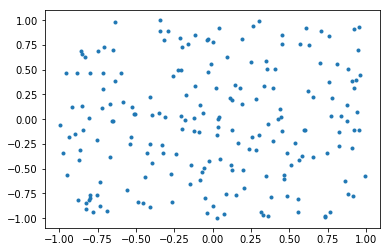

In [5]:
plt.plot(X[:,0],X[:,1],'.')

In [6]:
def classifier1(X):
    # this takes an arry of input points and calculates y values that are 1 on one side of a sloping line
    return(np.sum( X * [0.8,0.2], axis=1) > 0.3).astype(float)

In [7]:
y1 = classifier1(X)

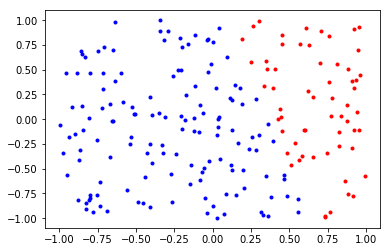

In [8]:
plt.plot(X[y1==0.0,0],X[y1==0.0,1],'b.')
plt.plot(X[y1==1.0,0],X[y1==1.0,1],'r.')

In [9]:
def classifier2(X):
    return (np.sum( X * X, axis=1) < 0.66 ).astype(float)

In [11]:
y2 = classifier2( X ) 

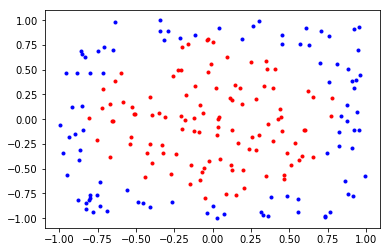

In [12]:
plt.plot(X[y2==0.0,0],X[y2==0.0,1],'b.')
plt.plot(X[y2==1.0,0],X[y2==1.0,1],'r.')

## Defining neuron activation functions

Here is code for a "leaky RELU" activation function, and a logistic activatio function. 

Note that we need to define **two** Python functions for each: the **forward pass** function, which computes the neuron's output from its total input; and the **bacward pass** function which computes the gradient of the outputs for small changes in the inputs.  This gradient is then fed back to earlier layers

In [14]:
def relu_outputs(inputs):
    """ 
    This is the function used in the forward pass,
    which computes the output of each 'neuron' in from the total of inputs
    
    inputs : a ndarray of the total input for each neuron
    
    returns: a ndarray giving the output for each neuron
    """
    return np.maximum(inputs,0) + 0.05 * np.minimum(inputs,0)


In [25]:
def relu_gradients(outputs):
    return (outputs > 0 ).astype(float) + 0.05 * (outputs < 0).astype(float)


Since we are approximating zeros and 1s, it is useful also to define a sigmoid neuron as the output, 
which has a minimum output value of 0 and a maximum output value of 1.

In this neural net we will only have one output neuron, but we define the function to accept a matrix of output neurons anyway. 

In [75]:
def sigmoid_outputs( inputs ):
    return  1.0 / (1.0 + np.exp( -inputs ))

In [76]:
def sigmoid_gradients( outputs ):
    return outputs * (1.0 - outputs)

Next, we define a one hidden layer neural net as a class. 

This class has quite a lot of data: 

In [273]:
class NN2layer:
    
    def __init__(self, n_inputs, n_layer_1): # one hidden layer of neurons, one output neuron
        
        self.n_inputs = n_inputs       # integer: the number of inputs. In this case, always 2
        self.n_layer_1 = n_layer_1     # integer: the number of neurons in the first (hidden) layer
        self.n_layer_2 = 1             # integer: the number of output neurons, in this case always 1 
        
        # weights that will be learned 
        # all these weights will need initialisation before the network is first run
        self.w_1 = np.zeros( [n_inputs, n_layer_1] ) # weights between inputs and first layer neurons
        self.bias_1 = np.zeros( [1, n_layer_1])
        self.w_2 = np.zeros( [n_layer_1, 1] ) # needs initialisation
        self.bias_2 = np.zeros( [1,1])
        
        # quantities calculated during forward pass
        self.X = np.zeros([1,n_inputs]) # the data example that is input ( a 1x2 matrix )
        
        self.inputs_layer_1 = np.zeros([1,n_layer_1])  # row-vector of total inputs to first layer neurons
        self.outputs_layer_1 = np.zeros([1,n_layer_1]) # row-vector of outputs of first layer neurons 
        
        self.inputs_layer_2 = np.zeros([1])   # row vector (in this case of length 1) of total input to second layer neuron
        self.outputs_layer_2 = np.zeros([1])  # row vector (in this case of length 1) of output of second layer neuron
        
        self.predicted_y = 0.0  # the predicted y value (just the output from the second layer neuron in this case)
        
        # quantities calculated during the backward pass
        # each one is initialised to a number or array of the correct size, with zeros
        # this is for readability, to show what the sizes should be
        # the actual values will be replaced during the calculation
        
        self.J = 0.0                 # the loss
        self.dJ_d_predicted_y = 0.0  # gradient of loss with respect to predicted y
        self.dJ_d_outputs_layer_2 = np.array([[0.0]]) 
        self.dJ_d_inputs_layer_2 = 0.0 # this is also dJ_d_bias_2, since bias is added to neuron inputs 
        self.dJ_d_w_2 = np.zeros( [n_layer_1, 1] ) # Same size as weight array  
        self.dJ_d_outputs_layer_1 = np.zeros([1,n_layer_1]) # same size as the vector of outputs (activations) of layer 1   
        self.dJ_d_inputs_layer_1 = np.zeros([1,n_layer_1]) 
        self.dJ_d_w_1 = np.zeros( [n_inputs, n_layer_1] ) 
        
        # in batch or minibatch mode, we average the gradients over many examples.  To do this, we need to 
        # do a forward and backward pass for each example in the batch, and then average the gradients, before
        # finally updating the weights. 
        
        self.n_backward_passes = 0  # number of backward passes in the batch so far 
        self.total_J = 0  # useful for monitoring average loss during training
        self.total_dJ_d_w_2 = np.zeros( [n_layer_1,1] ) # matches size of w_2
        self.total_dJ_d_w_1 = np.zeros( [n_inputs,n_layer_1] )
        self.total_dJ_d_bias_2 = np.zeros( [1,1] )
        self.total_dJ_d_bias_1 = np.zeros( [1, n_layer_1 ] )
        
    def initialise_weights(self, sigma_1, sigma_2):
        """
        Initialises layer 1 weights to zero-mean normal variates with standard deviation sigma_1, 
        and layer 2 weights to normal variates with s.d. sigma_2
        """
        self.w_1 = sigma_1 * np.random.randn( self.w_1.shape[0], self.w_1.shape[1] )
        self.bias_1 = sigma_1 * np.random.randn( 1, self.w_1.shape[1] )
        self.w_2 = sigma_2 * np.random.randn( self.w_2.shape[0], self.w_2.shape[1] )
        
    def forward_pass(self, X): 
        """
        computes the forward pass 
        
        X should be a vector of size [1,n_]
        """
        self.X = X.copy() # we might as well record the input vector; X may be a view or slice, so copy it
        assert self.X.shape == (1, self.n_inputs)
        
        self.inputs_layer_1 = np.dot(self.X, self.w_1 ) + self.bias_1
        self.outputs_layer_1 = relu_outputs( self.inputs_layer_1 )
        self.inputs_layer_2 = np.dot(self.outputs_layer_1, self.w_2 ) + self.bias_2
        self.outputs_layer_2 = sigmoid_outputs( self.inputs_layer_2 )
        self.predicted_y = self.outputs_layer_2[0,0]
    
    def squared_loss( self, y ): # the loss is modular: it needs to compute J, and the gradient of J
        """
        Called after calling forward_pass
        """
        self.J = 0.5 * (self.predicted_y - y)**2
        self.dJ_d_predicted_y = self.predicted_y - y 
        
    def backward_pass(self):
    
        self.dJ_d_outputs_layer_2[0,0] = self.dJ_d_predicted_y # computed by the loss function (e.g. squared_loss)
        self.dJ_d_inputs_layer_2 = sigmoid_gradients(self.outputs_layer_2) * self.dJ_d_outputs_layer_2
        self.dJ_d_w_2 = np.dot( self.outputs_layer_1.transpose(), self.dJ_d_inputs_layer_2 ) 
        self.dJ_d_outputs_layer_1 = np.dot( self.dJ_d_inputs_layer_2, self.w_2.transpose() )
        self.dJ_d_inputs_layer_1 = relu_gradients(self.outputs_layer_1) * self.dJ_d_outputs_layer_1
        self.dJ_d_w_1 = np.dot( self.X.transpose(), self.dJ_d_inputs_layer_1 )
        
        # now update cumulated gradients
        self.n_backward_passes += 1 
        self.total_J += self.J
        self.total_dJ_d_w_2 += self.dJ_d_w_2
        self.total_dJ_d_w_1 += self.dJ_d_w_1
        self.total_dJ_d_bias_2 += self.dJ_d_inputs_layer_2
        self.total_dJ_d_bias_1 += self.dJ_d_inputs_layer_1
        
    def update_weights(self, learning_rate ):
        assert self.n_backward_passes > 0  # otherwise all weights will go to Inf or NaN
        batch_learning_rate = learning_rate / self.n_backward_passes  
        self.w_1 -= batch_learning_rate * self.total_dJ_d_w_1
        self.bias_1 -= batch_learning_rate * self.total_dJ_d_bias_1
        self.w_2 -= batch_learning_rate * self.total_dJ_d_w_2
        self.bias_2 -= batch_learning_rate * self.total_dJ_d_bias_2
        
        # now clean up and set all total gradients and n_backward_passes to 0 
        self.n_backward_passes = 0 
        self.total_J = 0 
        self.total_dJ_d_w_2 *= 0 
        self.total_dJ_d_w_1 *= 0 
        self.total_dJ_d_bias_2 *= 0 
        self.total_dJ_d_bias_1 *= 0       
        
    

In [211]:
def plot_nn_predictions( nn ):
    x_values = np.linspace(-1,1,200)
    y_values = np.linspace(-1,1,200)

    J_grid = np.zeros([x_values.size,y_values.size])

    for x_index in range(0, x_values.size):
        for y_index in range(0, y_values.size):
            nn.forward_pass(np.array([[x_values[x_index], y_values[y_index] ]] ))
            J_grid[x_index,y_index] = nn.predicted_y
    
    plt.imshow(J_grid.transpose(), origin='lower',extent=[-1,1,-1,1])
    plt.colorbar()                                               

In [274]:
nn = NN2layer( 2,16)
nn.initialise_weights(0.2,0.2)

In [254]:
X = 2 * np.random.random((200,2)) - 1

Y = classifier2(X)

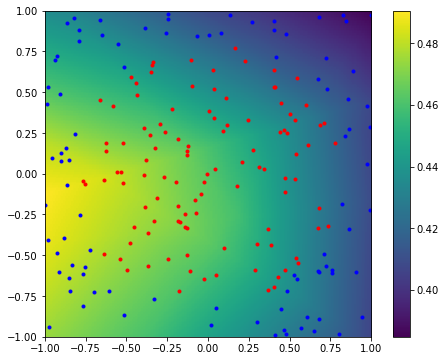

In [275]:
plot_nn_predictions(nn)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

Now do some training 

In [276]:
global_mean_J = []

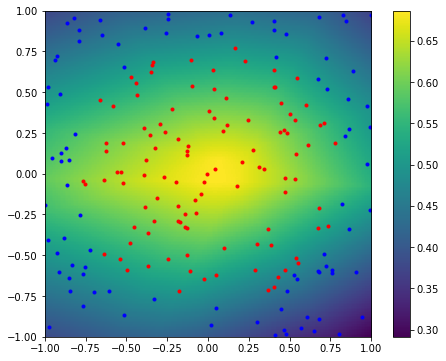

In [287]:
for j in range(0,1):
    for i in range(0,X.shape[0]):
        x_item = X[i:i+1,:]
        y = Y[i]
        nn.forward_pass(x_item)
        nn.squared_loss(y)
        nn.backward_pass()
    
        
    global_mean_J.append( nn.total_J / nn.n_backward_passes )
    nn.update_weights(0.1)
       
    
plot_nn_predictions(nn)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

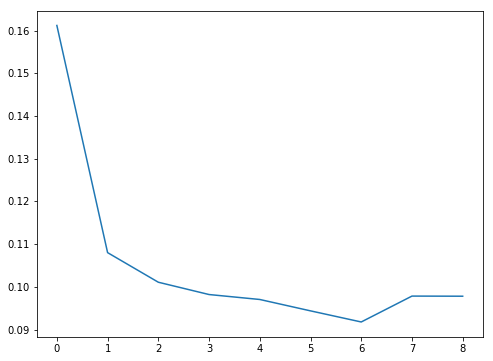

In [288]:
plt.rcParams["figure.figsize"] = [8,6]
plt.plot(global_mean_J)

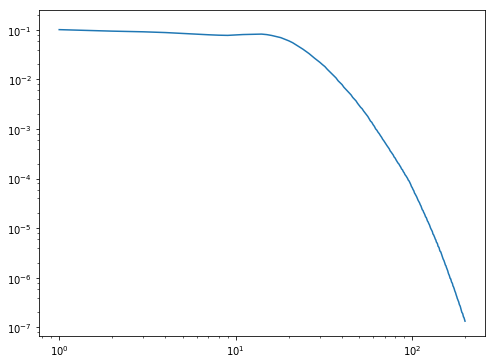

In [262]:
plt.loglog(global_mean_J)

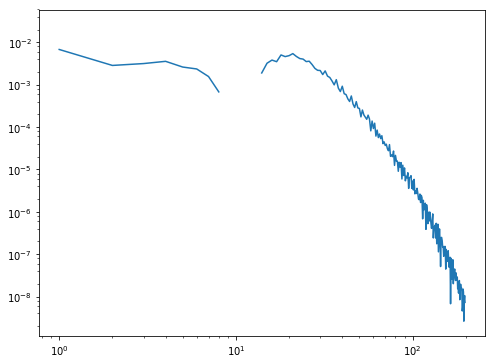

In [263]:
plt.loglog( -np.diff(np.array(global_mean_J)))

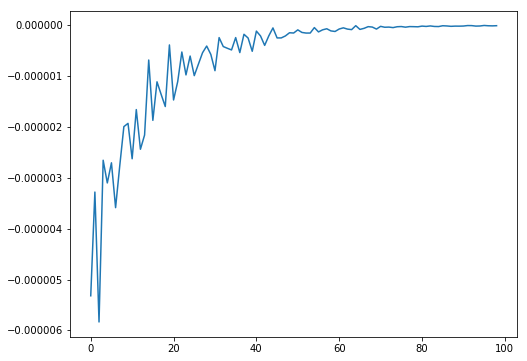

In [264]:
# Plot the last 100 changes in J

plt.plot( np.diff(np.array(global_mean_J)[-100:]))

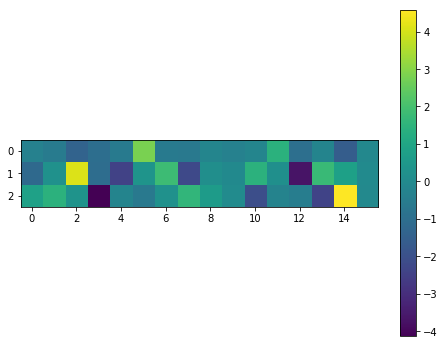

In [272]:
plt.imshow(np.vstack([nn.bias_1,nn.w_1]))
plt.colorbar()

The diagram above is a heatmap of the biases and weights of the first layer neurons. 

# Challenge: visualisation using heatmaps

It is worth visualising numerical algorithms in as many ways as possible. 

*  Are some first layer neurons not really being used?  To find out, calculate and record the activations (outputs) of all first  layer neurons for each example in the training set, and then look at the standard deviation of the output of each neuron, over the training set.  Display this as a heatmap or histogram. If a neuron is not generating different outputs for different values of the training set, it is not really being used. 


* Record the gradient for each first layer weight over for each of 100 training updates. Reshape the gradient matrices to row vectors, and stack them into a heatmap. 

To reshape a gradient matrix into a row vector, copy the gradient matrix from the NN object (it is important to copy it), and then reshape to a row vector, using `dJ_d_w_1.reshape(1,-1)`

To stack a list of 100 row vectors into a matrix, use `np.vstack( list_of_100_row_vectors )`
Display it with `plt.imshow`, as above. 

# Challenge: extend to 3 and 4 layers

Copy the NN2layer class code, put it into a new cell, and then alter it to include a second hidden layer, so that now you have a 3 layer NN.  

Does it learn so well?  

# Debugging:  Checking the Gradients

To get numerical code to work, you have to check your calculations in every way that you can think of. 

Back-propagation depends on gradients - so they had better be right.

It is quite straightforward to check gradients. 

Take an arbitrary x and y value. 
Run a forward pass, compute the loss, and then run a backward pass to compute all gradients. 

Record the gradients, for example, for first-layer weights. 

Now, estimate the gradient by a different method.  Vary the weight up and down, and compute the loss for each value of the weight, then compute the gradient of loss with respect to the weight directly, as shown below. 

In writing this notebook, I found my code contained several mistakes that I found by this method. 

In [111]:
test_x = np.array([[ 0.3, 0.2]])
test_y = 1.0

In [112]:
nn = NN2layer( 2, 4 )
nn.initialise_weights(0.5,0.5)

nn.forward_pass(test_x)
nn.squared_loss(test_y)
nn.backward_pass() # loss and gradients now computed

In [113]:
nn.J

0.21222689497734107

In [116]:
# calculate approximate values for gradients of layer 1 weights numerically 
delta = 0.01

dJ_d_w_1 = nn.dJ_d_w_1

w_1 = nn.w_1

estimated_dJ_d_w_1 = np.zeros( w_1.shape ) # array to contain estimated gradients that we will compute

for r in range(0,w_1.shape[0]):
    for c in range(0,w_1.shape[1]):
        w = w_1[r,c]
        
        nn.w_1[r,c] = w + delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jplus = nn.J  
        
        nn.w_1[r,c] = w - delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jminus = nn.J
        
        nn.w_1[r,c] = w # return it to its previous value ! 
        
        estimated_dJ_d_w_1[r,c] = (Jplus - Jminus) / (2 * delta)
        
        
dJ_d_w_1, estimated_dJ_d_w_1  # just print them both out and compare. 
# Or we could subtract and check differences are small


(array([[-0.01922278,  0.04547805,  0.00486158, -0.00110465],
        [-0.01281518,  0.0303187 ,  0.00324106, -0.00073643]]),
 array([[-0.01922277,  0.045478  ,  0.00486158, -0.00110465],
        [-0.01281518,  0.03031868,  0.00324106, -0.00073643]]))

In [117]:
# calculate approximate values for gradients of layer 1 weights numerically 
delta = 0.01

dJ_d_bias_1 = nn.dJ_d_inputs_layer_1

bias_1 = nn.bias_1

estimated_dJ_d_bias_1 = np.zeros( bias_1.shape ) # array to contain estimated gradients that we will compute

for r in range(0,bias_1.shape[0]):
    for c in range(0,bias_1.shape[1]):
        w = bias_1[r,c]
        
        nn.bias_1[r,c] = w + delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jplus = nn.J  
        
        nn.bias_1[r,c] = w - delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jminus = nn.J
        
        nn.bias_1[r,c] = w # return it to its previous value ! 
        
        estimated_dJ_d_bias_1[r,c] = (Jplus - Jminus) / (2 * delta)
        
        
dJ_d_bias_1, estimated_dJ_d_bias_1


(array([[-0.06407592,  0.15159349,  0.01620528, -0.00368216]]),
 array([[-0.06407578,  0.15159169,  0.01620528, -0.00368216]]))

In [118]:
# calculate approximate values for gradients of layer 2 weights numerically 
delta = 0.01

dJ_d_w_2 = nn.dJ_d_w_2 

w_2 = nn.w_2

estimated_dJ_d_w_2 = np.zeros( w_2.shape )

for r in range(0,w_2.shape[0]):
    for c in range(0,w_2.shape[1]):
        w = w_2[r,c]
        
        nn.w_2[r,c] = w + delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jplus = nn.J  
        
        nn.w_2[r,c] = w - delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jminus = nn.J
        
        nn.w_2[r,c] = w # return it to its previous value ! 
        
        estimated_dJ_d_w_2[r,c] = (Jplus - Jminus) / (2 * delta)
        
        
dJ_d_w_2, estimated_dJ_d_w_2


(array([[-0.01182456],
        [-0.09222086],
        [-0.00505071],
        [ 0.00523261]]), array([[-0.01182456],
        [-0.09222046],
        [-0.00505071],
        [ 0.00523261]]))

In [119]:
# calculate approximate values for gradients of layer 2 bias numerically 
delta = 0.01

dJ_d_bias_2 = nn.dJ_d_inputs_layer_2 

bias_2 = nn.bias_2

estimated_dJ_d_bias_2 = np.zeros( bias_2.shape )

for r in range(0,bias_2.shape[0]):
    for c in range(0,bias_2.shape[1]):
        w = bias_2[r,c]
        
        nn.bias_2[r,c] = w + delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jplus = nn.J  
        
        nn.bias_2[r,c] = w - delta
        nn.forward_pass( test_x )
        nn.squared_loss( test_y )
        Jminus = nn.J
        
        nn.bias_2[r,c] = w # return it to its previous value ! 
        
        estimated_dJ_d_bias_2[r,c] = (Jplus - Jminus) / (2 * delta)
        
        
dJ_d_bias_2, estimated_dJ_d_bias_2


(array([[-0.14792164]]), array([[-0.14791997]]))